<a href="https://colab.research.google.com/github/bluecityisu/class2022/blob/main/ch11_gru_bi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.12.0


In [2]:
def get_data():
    data_file = "/content/drive/MyDrive/TensorFlow_Book/Deep_learning_coder/station.csv"
    f = open(data_file)
    data = f.read()
    f.close()
    lines = data.split('\n')
    header = lines[0].split(',')
    lines = lines[1:]
    temperatures=[]
    for line in lines:
        if line:
            linedata = line.split(',')
            linedata = linedata[1:13]
            for item in linedata:
                if item:
                    temperatures.append(float(item))

    series = np.asarray(temperatures)
    time = np.arange(len(temperatures), dtype="float32")      
    return time, series


In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std
split_time = 780
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
     

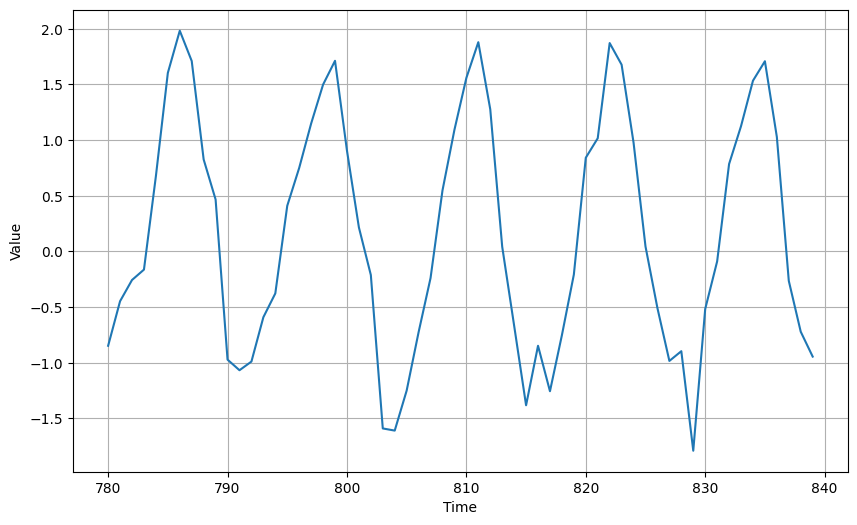

In [5]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
     

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
# Experiment with this to play with accuracy. Do note that
# this is a small dataset, so a large window size may
# cause errors.
window_size = 40
batch_size = 20
shuffle_buffer_size = 20

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True, dropout=0.1, recurrent_dropout=0.1)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1)), 
  tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.legacy.SGD(lr=1e-4, momentum=0.7)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=100,  verbose=1, validation_data=valid_dataset)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


37/37 [==============================] - 46s 686ms/step - loss: 0.4536 - mae: 0.8634 - val_loss: 0.5362 - val_mae: 0.9624
Epoch 2/500
37/37 [==============================] - 27s 723ms/step - loss: 0.4507 - mae: 0.8600 - val_loss: 0.5339 - val_mae: 0.9601
Epoch 3/500
37/37 [==============================] - 23s 614ms/step - loss: 0.4490 - mae: 0.8575 - val_loss: 0.5317 - val_mae: 0.9578
Epoch 4/500
37/37 [==============================] - 21s 571ms/step - loss: 0.4461 - mae: 0.8549 - val_loss: 0.5294 - val_mae: 0.9555
Epoch 5/500
37/37 [==============================] - 23s 633ms/step - loss: 0.4443 - mae: 0.8527 - val_loss: 0.5272 - val_mae: 0.9532
Epoch 6/500
37/37 [==============================] - 22s 607ms/step - loss: 0.4418 - mae: 0.8489 - val_loss: 0.5249 - val_mae: 0.9509
Epoch 7/500
37/37 [==============================] - 23s 625ms/step - loss: 0.4399 - mae: 0.8471 - val_loss: 0.5227 - val_mae: 0.9486
Epoch 8/500
37/37 [==============================] - 23s 616ms/step - loss

In [8]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

2/2 [==============================] - 1s 68ms/step


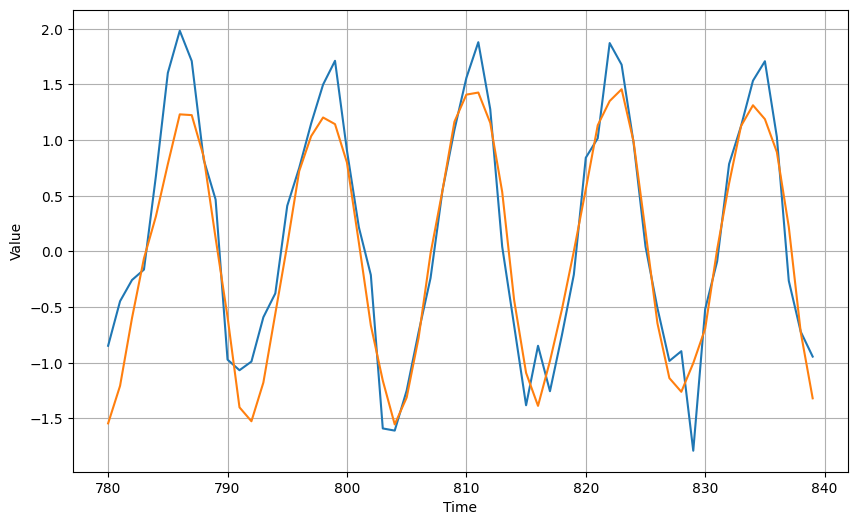

In [10]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)
plt.show()


In [11]:
mae = tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()
print(mae)

0.29314387


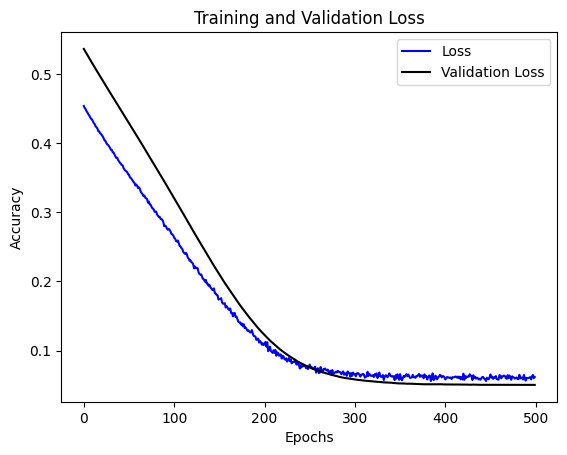

<Figure size 640x480 with 0 Axes>

In [12]:
mae=history.history['mae']
loss=history.history['loss']
val_mae=history.history['val_mae']
val_loss=history.history['val_loss']
epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
#plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
#plt.plot(epochs, val_mae, 'g')
plt.plot(epochs, val_loss, 'k')
plt.title('Training and Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
plt.show()